In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [2]:
df = pd.read_csv('dataset_clean.csv')

## Train Test Split

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
RSEED = 101

In [5]:
df.columns

Index(['Date', 'price', 'res_load', 'temp', 'wind', 'gen_total', 'gen_bio',
       'gen_hyd', 'gen_windoff', 'gen_windon', 'gen_pv', 'gen_reother',
       'gen_nuc', 'gen_bcoal', 'gen_hcoal', 'gen_gas', 'gen_pump', 'gen_other',
       'gen_f_total', 'gen_f_windoff', 'gen_f_windon', 'gen_f_pv',
       'gen_f_other', 'dm', 'dm_f', 'netex', 'mres+', 'mres-', 'sres+',
       'sres-', 'FF', 'gen_delta', 'gen_windoff_delta', 'gen_windon_delta',
       'gen_pv_delta', 'dm_delta', 'dm_gen_delta', 'dm_gen_ratio', 'day',
       'weekend', 'month', 'season', 'hour', 'peak', 'lag1', 'price_change',
       'price_diff', 'price_diff_pos', 'price_pos', 'price_diff_bins'],
      dtype='object')

In [6]:
X1 = df[['res_load', 'temp', 'wind', 'gen_total', 'gen_bio',
       'gen_hyd', 'gen_windoff', 'gen_windon', 'gen_pv', 'gen_reother',
       'gen_nuc', 'gen_bcoal', 'gen_hcoal', 'gen_gas', 'gen_pump', 'gen_other',
       'gen_f_total', 'gen_f_windoff', 'gen_f_windon', 'gen_f_pv',
       'gen_f_other', 'dm', 'dm_f', 'netex', 'mres+', 'gen_delta', 'gen_windoff_delta', 'gen_windon_delta',
       'gen_pv_delta', 'dm_delta', 'day', 'month', 'season', 'hour',
       'peak']]

In [17]:
X = X1
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)

## Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## AdaBoost

In [8]:
ada = AdaBoostRegressor(random_state=RSEED, n_estimators=100)
ada.fit(X_train, y_train)
predictions = ada.predict(X_test)

In [9]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Explained Variance Score
evs = explained_variance_score(predictions, y_test)

# Print metrics
print('Mean Absolute Error:', round(mae, 5))
print('Mean Squared Error:', round(mse, 5))
print('R-squared scores:', round(r2, 5))
print('Explained Variance Score:', round(evs, 5))

Mean Absolute Error: 6.31636
Mean Squared Error: 65.01985
R-squared scores: 0.78808
Explained Variance Score: 0.7595


## Hyperparameter Tuning via Randomized Search

In [24]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [5, 100],
 'learning_rate' : [0.1,0.5,1],
 'loss' : ['linear', 'square', 'exponential']
 }

pre_gs_inst = RandomizedSearchCV(AdaBoostRegressor(),
param_distributions = param_dist,
cv=3,
n_iter = 10,
n_jobs=-1)

pre_gs_inst.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=None,
                                               learning_rate=1.0, loss='linear',
                                               n_estimators=50,
                                               random_state=None),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.5, 1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [5, 100]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [25]:
pre_gs_inst.best_params_

{'n_estimators': 100, 'loss': 'exponential', 'learning_rate': 1}

### Best Model

In [30]:
ada_best = AdaBoostRegressor(base_estimator=None,
                                               learning_rate=1.0, loss='linear',
                                               n_estimators=50,
                                               random_state=None)
                   
ada_best.fit(X_train, y_train)
predictions = ada_best.predict(X_test)

In [31]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Explained Variance Score
evs = explained_variance_score(predictions, y_test)

# Print metrics
print('Mean Absolute Error:', round(mae, 5))
print('Mean Squared Error:', round(mse, 5))
print('R-squared scores:', round(r2, 5))
print('Explained Variance Score:', round(evs, 5))

Mean Absolute Error: 6.12392
Mean Squared Error: 62.86891
R-squared scores: 0.79509
Explained Variance Score: 0.74735


## Feature Importance

In [33]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X.columns.values[indices[:7]]
    values = importances[indices][:7]

    # Creat the plot
    fig = plt.figure(figsize = (15,8))
    plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(7), values, width = 0.5, align="center", color = '#FF4343', \
          label = "Feature Weight")
    plt.bar(np.arange(7) - 0.3, np.cumsum(values), width = 0.5, align = "center", color = 'k', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns, rotation=70)
    plt.xlim((-0.5, 6.5))
    plt.ylabel("Weight", fontsize = 16)
    plt.xlabel("Feature", fontsize = 16)
    
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('font', size=16)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

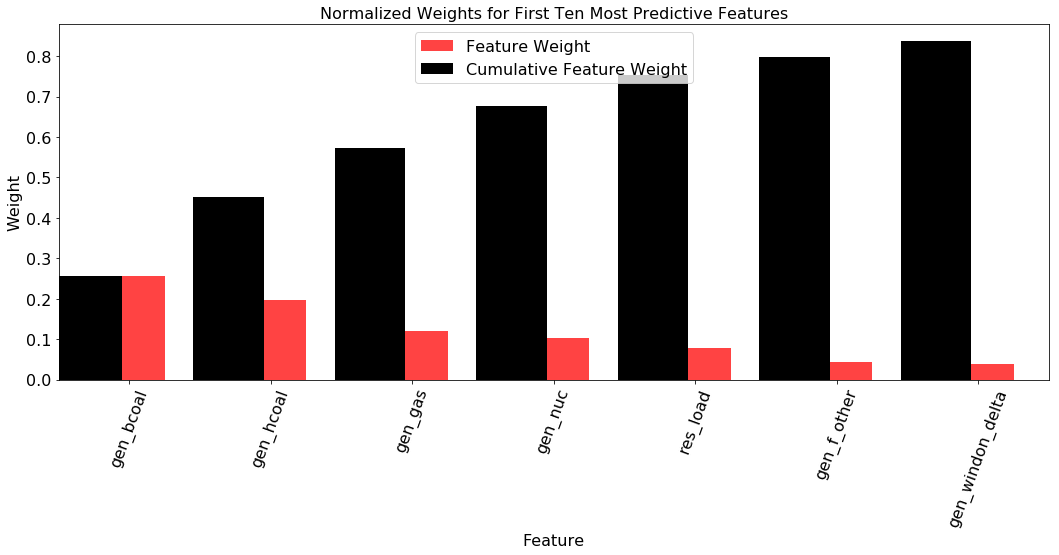

In [34]:
# TODO: Train the supervised model on the training set 
model = AdaBoostRegressor().fit(X_train,y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)